## Run VMSI pipeline for mouse E8.5 embryo dorsal region

Import required modules

In [1]:
import sys
sys.path.append('../')

import numpy as np
from src.VMSI import *
from src.segment import Segmenter
import skimage
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
import seaborn as sns
import os

Load image:

In [2]:
curr_wd = os.getcwd()
img = skimage.io.imread(f'{curr_wd}/../example_data/mouse_dorsal_seqFISH/segmented_image.tif')


Here, the image has been segmented, but the labels are touching. VMSI requires labels to be separated by
one-pixel wide, 4-connected boundaries representing the cell-cell junctions. We can get these boundaries using
the `find_boundaries()` function from `scikit-image`:

In [3]:
img = skimage.segmentation.find_boundaries(img, mode='subpixel')

# find_boundaries returns a binary mask of boundaries; convert this back to labelled image
img = skimage.measure.label(1-img)

This image also contains holes; that is, the image does not contain a contiguous sheet of cells. To deal with
this, Tensionmap must be provided with a binary mask labelling the location of interior holes. As all the holes in this
image are much larger than cells, we can simply denote labels with greater than 5 times the
mean cell area as holes.

In [4]:
# Filter for holes
holes_mask = np.zeros_like(img)
areas = pd.DataFrame(skimage.measure.regionprops_table(label_image=img, properties=('label','area')))
thresh = np.mean(areas['area'].tolist())*5
for area in areas.iterrows():
    if area[1]['area'] > thresh:
        holes_mask[img==area[1]['label']] = 1

Show the resulting labelled, processed image and holes mask:

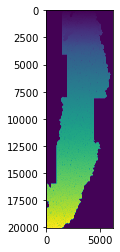

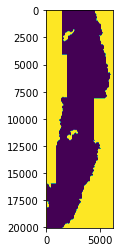

In [5]:
plt.figure()
plt.imshow(img)
plt.figure()
plt.imshow(holes_mask)

After these steps, we can run the one-step force inference and morphometrics as normal.

In [6]:
model = run_VMSI(img, is_labelled=True, holes_mask=holes_mask, optimiser='nlopt')

Next, plot the cell pressures and cell-cell junction tensions:

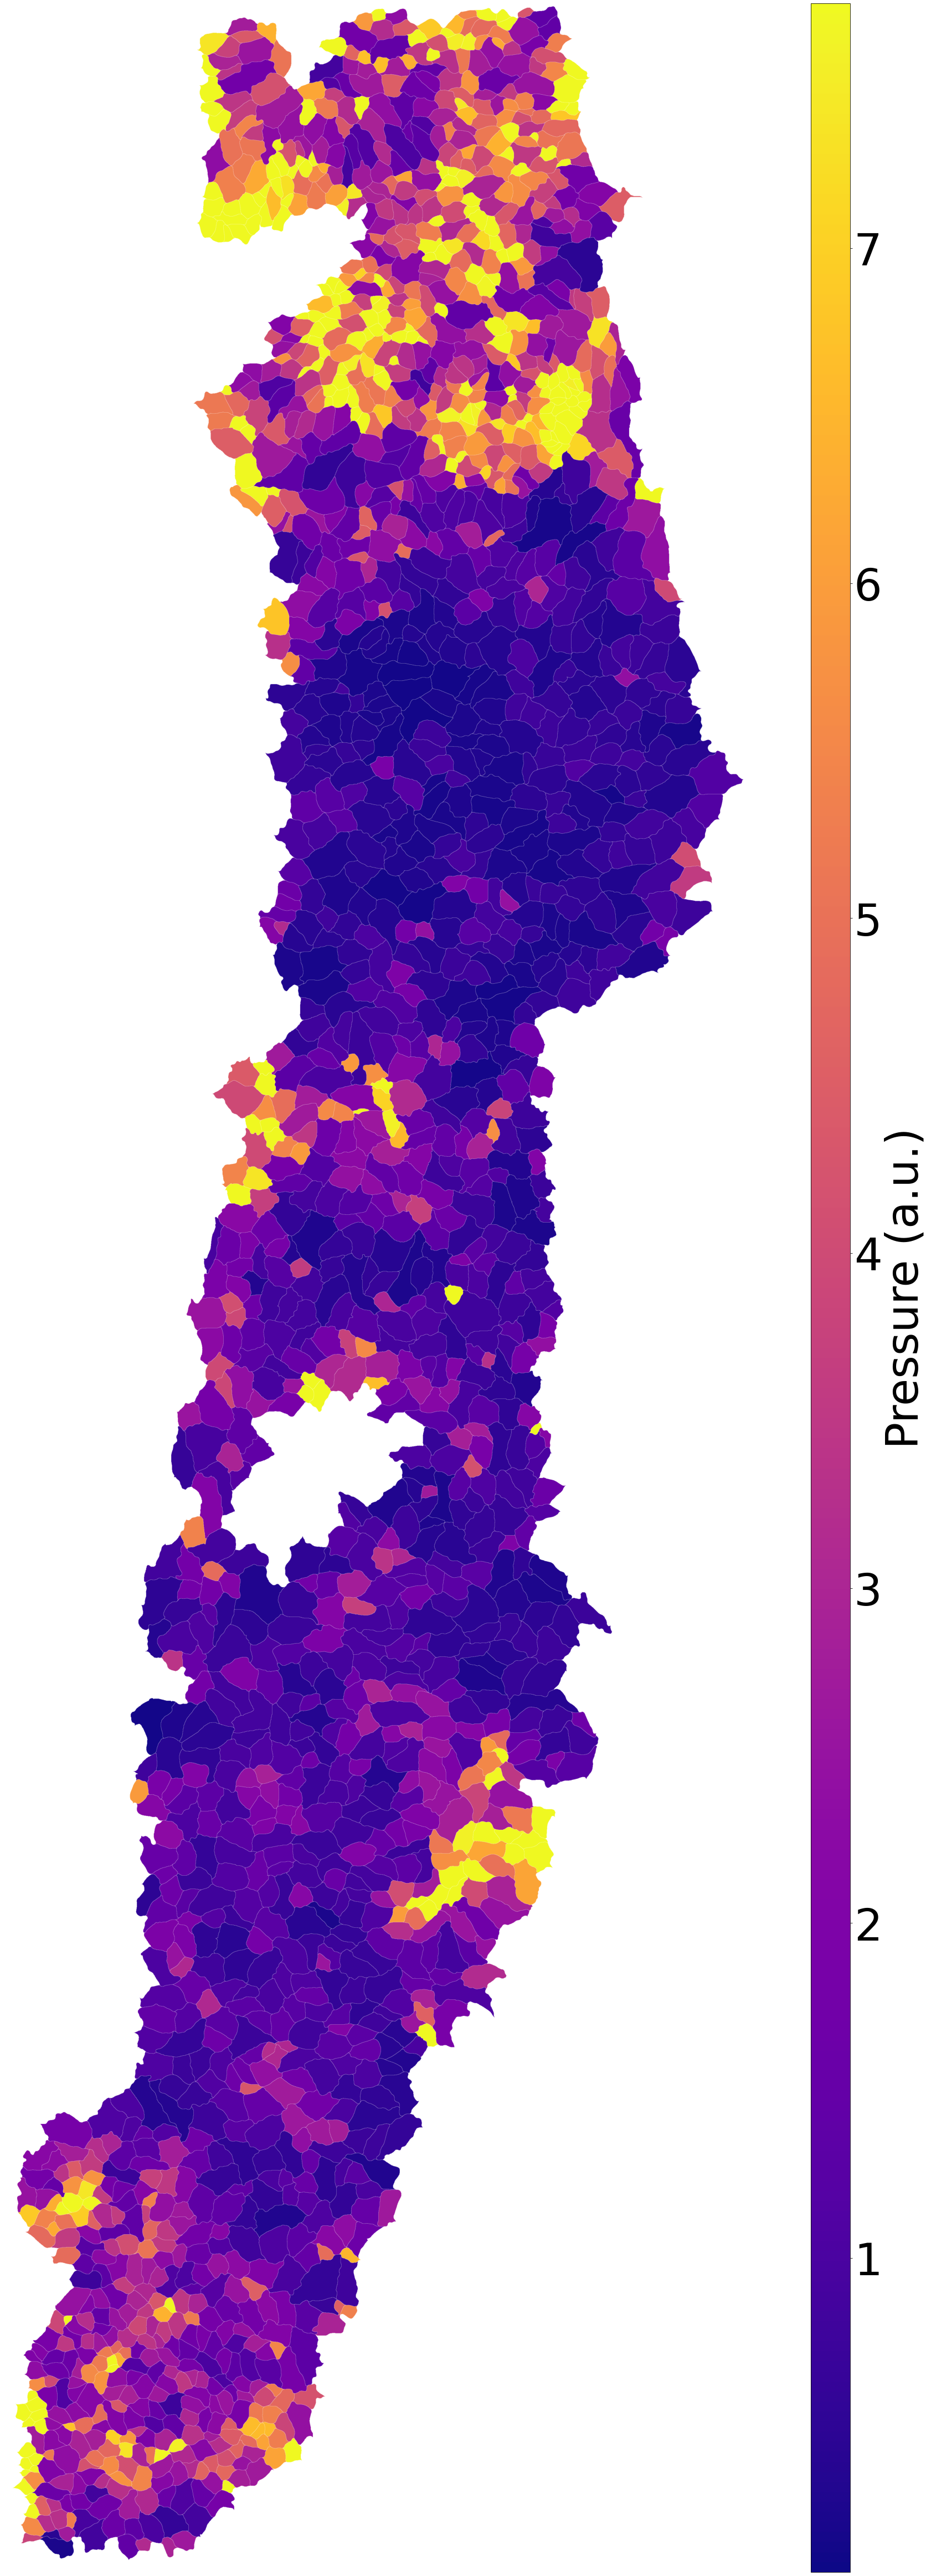

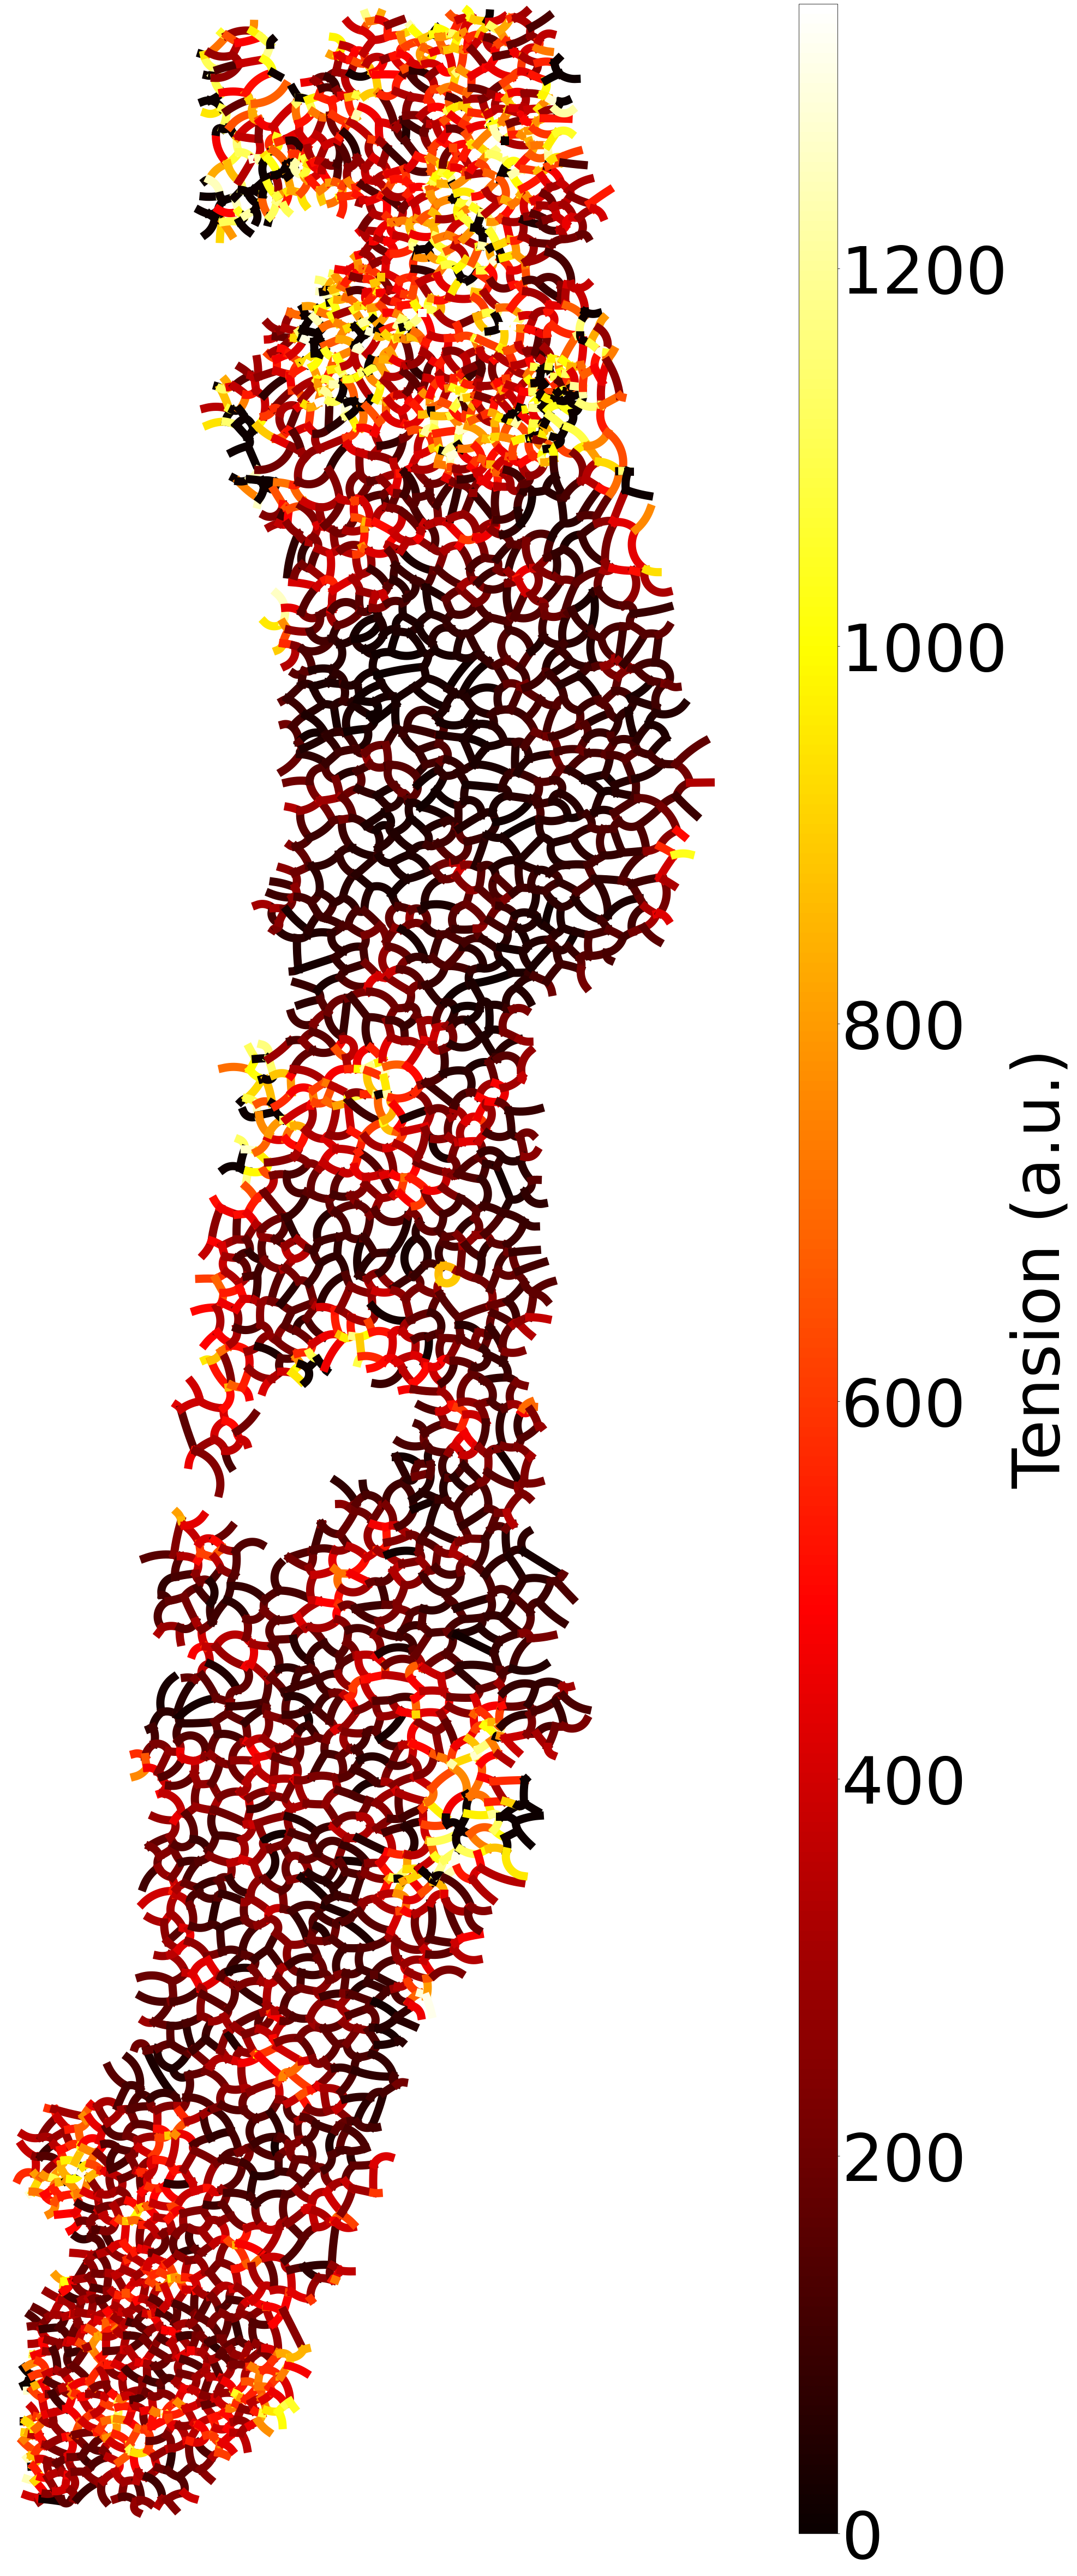

In [7]:
model.plot(['pressure'], img, size=80)
model.plot(['tension'], line_thickness=15, size=120)

In [8]:
matlab_model = run_VMSI(img, is_labelled=True, holes_mask=holes_mask, optimiser='matlab')

In [11]:
from scipy.stats import spearmanr